In [17]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

13568290/13568290 [==============================] - 2s 0us/step


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

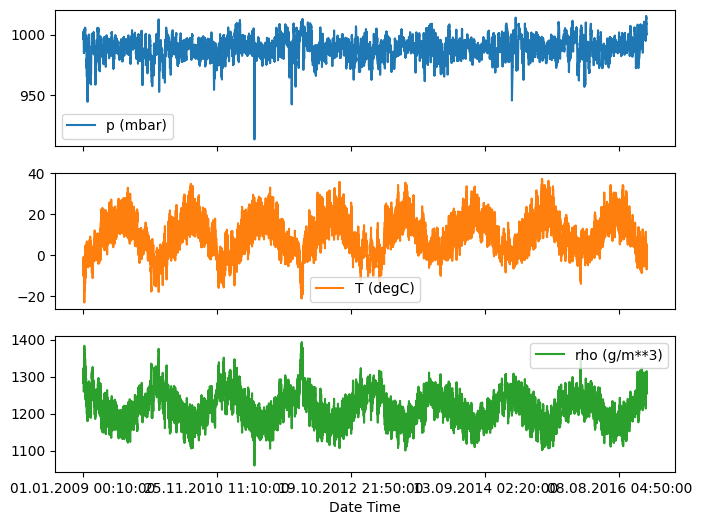

In [18]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']


zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
df.head()

features = df[features_considered]
features.index = df['Date Time']
features.head()
features.plot(subplots=True)

В обеих частях руководства первые 300 000 строк данных будут использоваться для обучения модели, оставшиеся – для её валидации (проверки). В этом случае объём обучающих данных составляет примерно 2100 дней.

In [19]:
TRAIN_SPLIT = 300000

Для обеспечения воспроизводимости результатов устанавливается функция seed.

In [20]:
tf.random.set_seed(13)

В данном случае модель обучается прогнозированию одного значения в будущем на основе некой имеющейся истории.
Приведенная ниже функция выполняет ту же задачу организации временных интервалов лишь с тем отличием, что здесь она отбирает последние наблюдения на основе заданного размера шага.

In [21]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

первым шагом будет выполнение стандартизации набора данных с вычислением среднего значения и стандартного отклонения обучающих данных.

In [22]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [23]:
dataTime = df['T (degC)']
dataTime.index = df['Date Time']
dataTime.head()
print(dataTime)

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
                       ... 
31.12.2016 23:20:00   -4.05
31.12.2016 23:30:00   -3.35
31.12.2016 23:40:00   -3.16
31.12.2016 23:50:00   -4.23
01.01.2017 00:00:00   -4.82
Name: T (degC), Length: 420551, dtype: float64


В данном руководстве ИНС оперирует данными за последние пять (5) дней, то есть 720 наблюдениями (6х24х5). Допустим, что отбор данных проводится не каждые 10 минут, а каждый час: в течение 60 минут резкие изменения не ожидаются. Следовательно, историю последних пяти дней составляют 120 наблюдений (720/6). Для модели, выполняющей точечное прогнозирование, целью является значение температуры через 12 часов в будущем. В этом случае целевой вектор будет составлять температура после 72 (12х6) наблюдений (см. следующее дополнение. – Прим. переводчика).

In [24]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

print ('Single window of past history : {}'.format(x_train_single[0].shape))


Single window of past history : (120, 3)


Передаваемая в ИНС информация выделена синим цветом, красным крестиком обозначено будущее значение, которое ИНС должна спрогнозировать.

In [25]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

Проверим временной интервал.

In [26]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Проверим нашу выборку и выведем кривые потерь на этапах обучения и проверки.

In [27]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

8/8 [==============================] - 1s 11ms/step
(256, 1)


In [28]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 17s 74ms/step - loss: 0.3095 - val_loss: 0.2649
Epoch 2/10
200/200 [==============================] - 13s 66ms/step - loss: 0.2627 - val_loss: 0.2523
Epoch 3/10
200/200 [==============================] - 13s 65ms/step - loss: 0.2576 - val_loss: 0.2410
Epoch 4/10
200/200 [==============================] - 13s 64ms/step - loss: 0.2564 - val_loss: 0.2414
Epoch 5/10
200/200 [==============================] - 13s 64ms/step - loss: 0.2244 - val_loss: 0.2352
Epoch 6/10
200/200 [==============================] - 13s 64ms/step - loss: 0.2393 - val_loss: 0.2651
Epoch 7/10
200/200 [==============================] - 13s 65ms/step - loss: 0.2416 - val_loss: 0.2593
Epoch 8/10
200/200 [==============================] - 13s 63ms/step - loss: 0.2369 - val_loss: 0.2452
Epoch 9/10
200/200 [==============================] - 13s 65ms/step - loss: 0.2427 - val_loss: 0.2565
Epoch 10/10
200/200 [==============================] - 13s 67ms/step - loss: 0.239

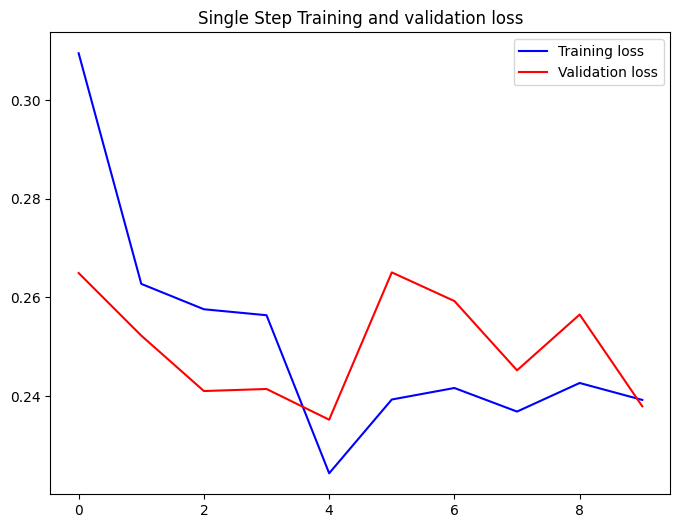

8/8 [==============================] - 0s 10ms/step


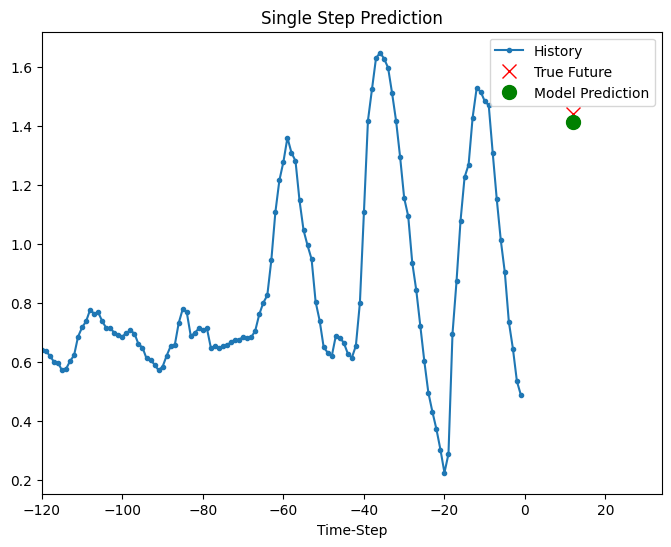

8/8 [==============================] - 0s 10ms/step


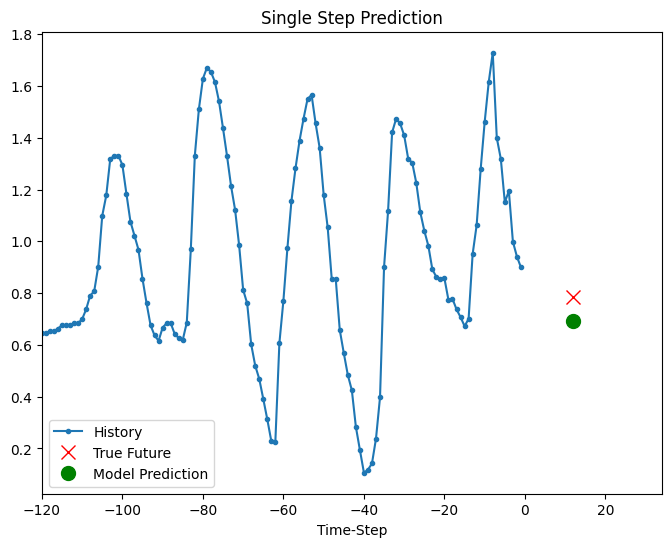

8/8 [==============================] - 0s 10ms/step


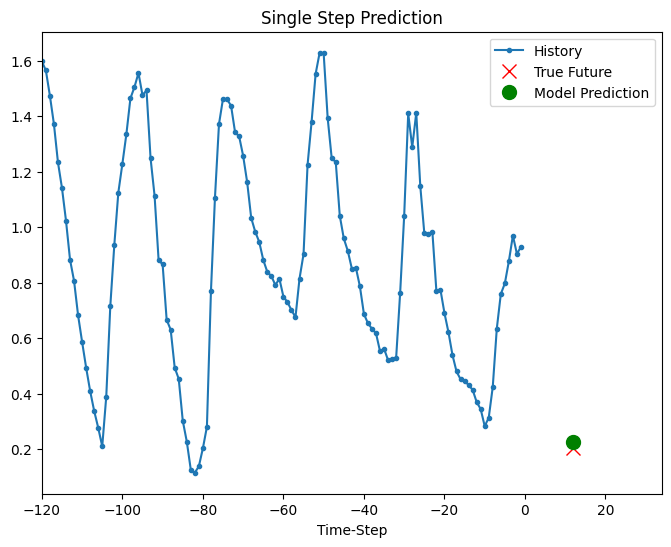

In [29]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

Для одномерного

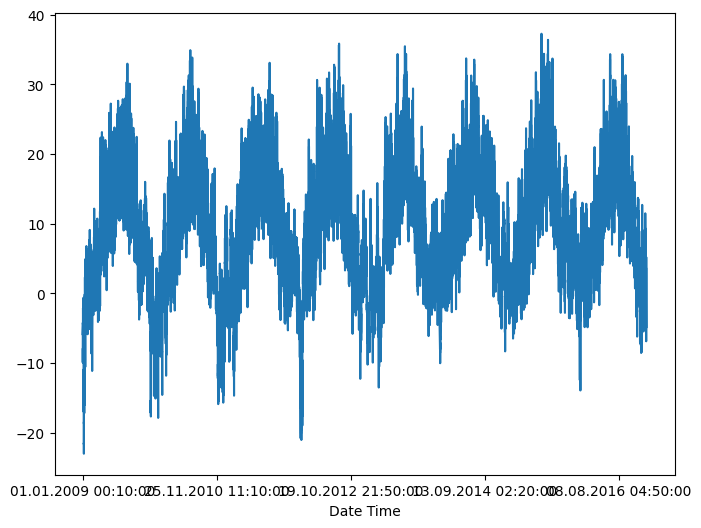

In [30]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()
uni_data.plot(subplots=True)
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


<module 'matplotlib.pyplot' from 'C:\\Users\\nbdxd\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\matplotlib\\pyplot.py'>

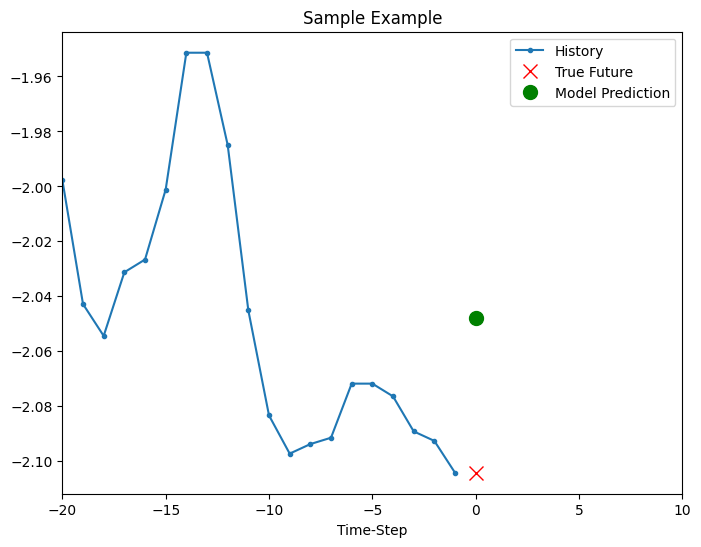

In [31]:



def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

def baseline(history):
  return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Sample Example')

Интервальное

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


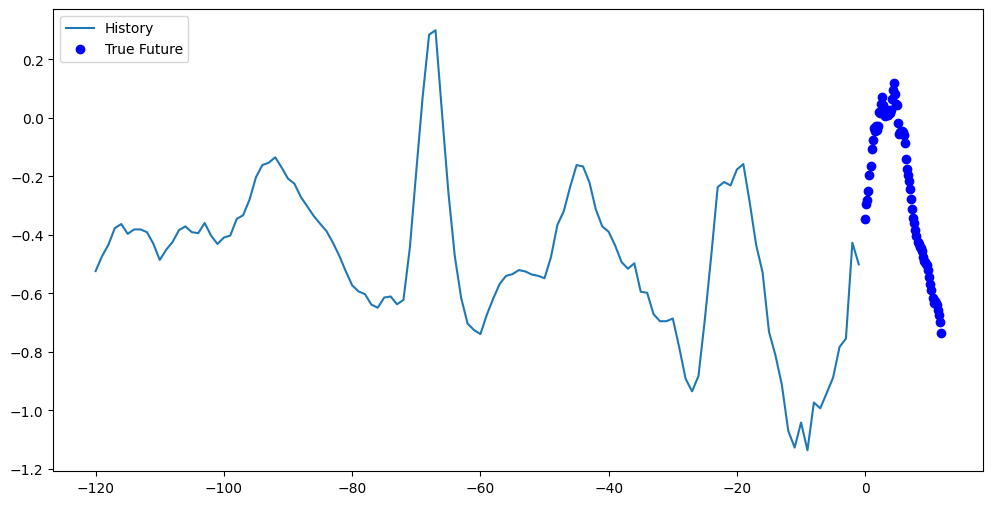

8/8 [==============================] - 1s 16ms/step
(256, 72)
Epoch 1/10
200/200 [==============================] - 28s 124ms/step - loss: 0.5805 - val_loss: 0.3151
Epoch 2/10
200/200 [==============================] - 24s 119ms/step - loss: 0.4639 - val_loss: 0.2782
Epoch 3/10
200/200 [==============================] - 24s 122ms/step - loss: 0.3419 - val_loss: 0.2564
Epoch 4/10
200/200 [==============================] - 25s 125ms/step - loss: 0.2640 - val_loss: 0.2230
Epoch 5/10
200/200 [==============================] - 25s 125ms/step - loss: 0.2079 - val_loss: 0.2115
Epoch 6/10
200/200 [==============================] - 25s 123ms/step - loss: 0.2150 - val_loss: 0.2123
Epoch 7/10
200/200 [==============================] - 25s 127ms/step - loss: 0.2062 - val_loss: 0.2183
Epoch 8/10
200/200 [==============================] - 26s 130ms/step - loss: 0.2028 - val_loss: 0.2086
Epoch 9/10
200/200 [==============================] - 29s 144ms/step - loss: 0.2053 - val_loss: 0.1880
Epoch 10/10

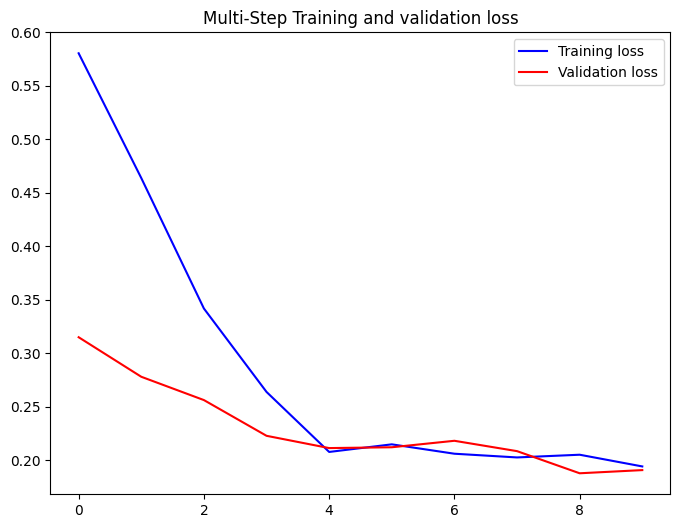

8/8 [==============================] - 0s 18ms/step


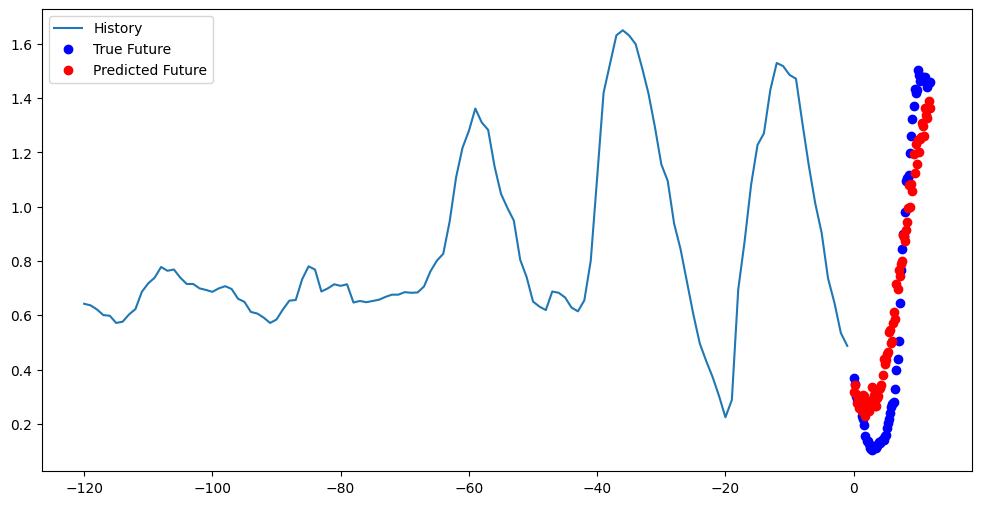

8/8 [==============================] - 0s 17ms/step


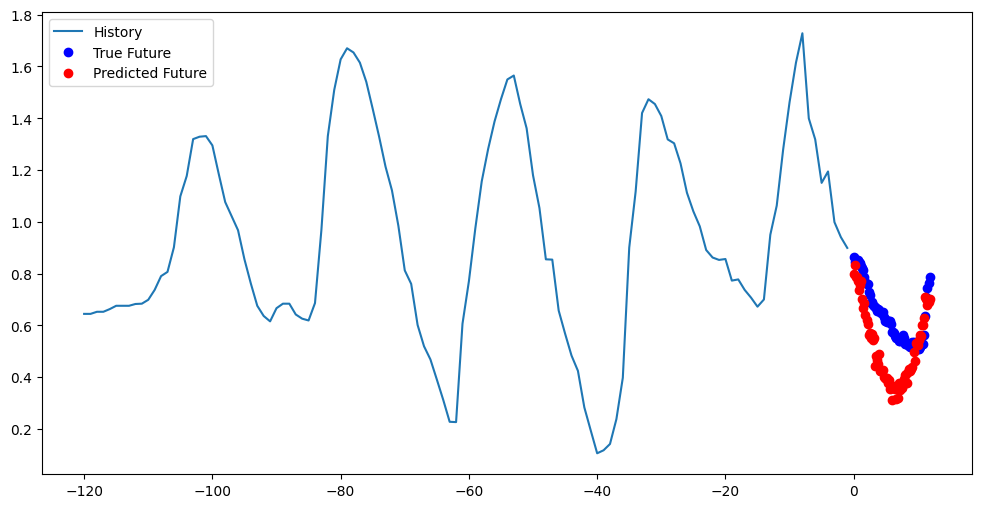

8/8 [==============================] - 0s 20ms/step


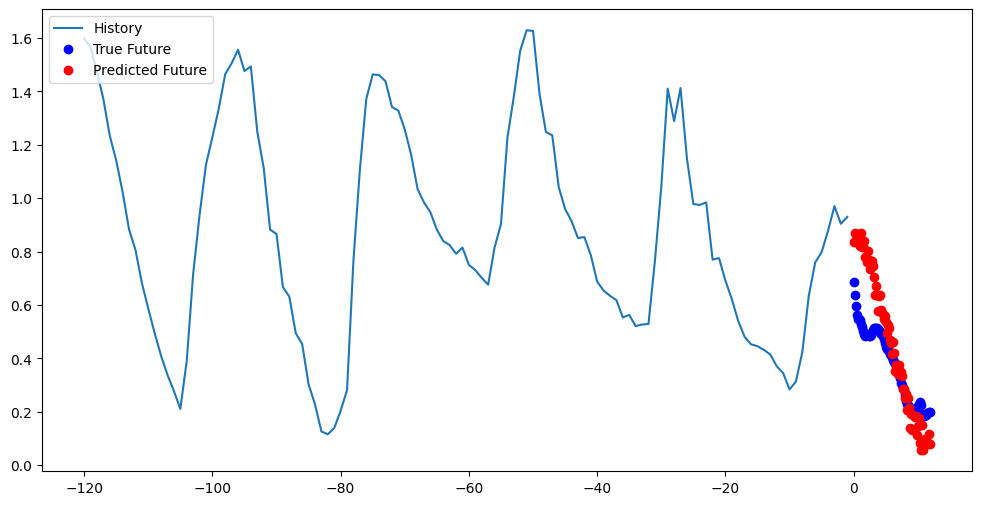

In [32]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))


train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))


multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')


for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)


  multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)
  
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])